## Importando Bibliotecas

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns; sns.set() 



In [4]:
df = pd.read_csv("/Users/lucas/TCC/deputados_federais_com_financiamento.csv")

## Limpeza

In [5]:
df['Decision'] = 'NaN'

In [6]:
for index, row in df.iterrows():
    if row['DS_SIT_TOT_TURNO'] == "SUPLENTE" or row['DS_SIT_TOT_TURNO'] == "N�O ELEITO" or row['DS_SIT_TOT_TURNO'] == "#NULO#" :
        df.loc[index,'Decision'] = 0
    else: df.loc[index,'Decision'] = 1

In [7]:
## fatorando

df['SG_PARTIDO_F'] = pd.factorize(df['SG_PARTIDO'])[0]
df['ST_REELEICAO_F'] = pd.factorize(df['ST_REELEICAO'])[0]
df['ST_DECLARAR_BENS_F'] = pd.factorize(df['ST_DECLARAR_BENS'])[0]


In [8]:
## Utilizando todo o sample

sample = df[["CD_SITUACAO_CANDIDATURA","SQ_COLIGACAO","NR_IDADE_DATA_POSSE","CD_GENERO","CD_ESTADO_CIVIL",
             "CD_COR_RACA","CD_OCUPACAO","VR_DESPESA_MAX_CAMPANHA","FIN_COMERCIALIZACAO_DE_BENS_EVENTOS",
             "FIN_DOACAO_PELA_INTERNET","FIN_RECURSOS_FINANCIAMENTO_COLETIVO","FIN_ORIGEM_NAO_IDENTIFICADA",
             "FIN_RECURSOS_OUTROS_CANDIDATOS","FIN_PARTIDO_POLITICO","FIN_RECURSOS_PESSOAS_FISICAS",
             "RECURSOS_PROPRIOS","FIN_APLICACOES_FINANCEIRAS","SG_PARTIDO_F","ST_REELEICAO_F","ST_DECLARAR_BENS_F","Decision"]]

In [9]:
sample.dropna(inplace=True)

c:\users\lucas\appdata\local\programs\python\python38\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [10]:
sample.Decision=sample.Decision.astype('int')

c:\users\lucas\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [11]:
X = sample.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]]
y = sample.Decision
y=y.astype('int')

# Aplicando clusterizacao 

http://repositorio.poli.ufrj.br/monografias/monopoli10031868.pdf

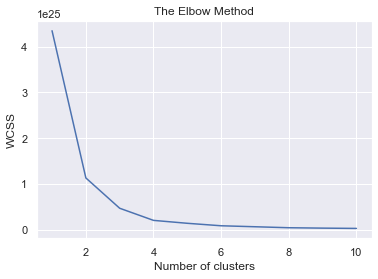

In [19]:
# Getting the number of clusters
wcss = []
for index in range(1, 11):
    kmeans = KMeans(n_clusters = index,
        init = 'k-means++',
        max_iter = 300,
        n_init = 10)
    kmeans.fit(sample)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show() 

In [26]:
 # Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 300, n_init = 10)
sample['Clusters'] = kmeans.fit_predict(sample) 

c:\users\lucas\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [27]:
# Run PCA on the data and reduce the dimensions in pca_num_components dimensions
reduced_data = PCA(n_components=2).fit_transform(sample)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2']) 

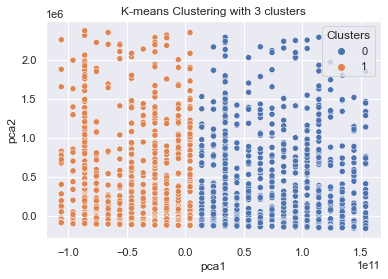

In [28]:
# Visualising the clusters
sns.scatterplot(x="pca1", y="pca2", hue=sample['Clusters'], data=results)
plt.title('K-means Clustering with 3 clusters')
plt.show()

## modelo básico

In [29]:
import pandas as pd
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt 

In [30]:
X, y = sample.iloc[:,:-1], sample.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

In [31]:
 # Create a dummy regressor
dummy = DummyRegressor(strategy='median') #median or mean 

In [32]:
# "Train" dummy regressor
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test) 

In [33]:
# Get RMSE
rmse = sqrt(mean_squared_error(y_pred, y_test))
print(rmse)

0.641048326514202


## classificação

In [13]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt 

In [14]:
 # Aplying one hot encoder to segment
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])],
remainder='passthrough')
data = ct.fit_transform(sample)

In [15]:
# Splitting into training set and test set
X, y = data[:,:-1], data[:,-1]
data_dmatrix = xgb.DMatrix(data=X, label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

c:\users\lucas\appdata\local\programs\python\python38\lib\site-packages\xgboost\data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [16]:
# Fitting XGBoost to training set and predict
module = xgb.XGBClassifier(objective ='reg:squarederror',
            colsample_bytree = 0.5,
            learning_rate = 0.3, max_depth = 15,
            alpha = 10, n_estimators = 60)
module.fit(X_train, y_train)
print(module.get_num_boosting_rounds())
y_pred = module.predict(X_test) 

c:\users\lucas\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


60


In [17]:
# K-fold
params = {"objective":"reg:squarederror",
            'colsample_bytree': 0.5,'learning_rate': 0.3,
            'max_depth': 15, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
        num_boost_round=60, early_stopping_rounds=10,
        metrics="rmse", as_pandas=True)
cv_results.head()
print((cv_results))

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          0.375168        0.000792        0.376145       0.000622
1          0.295050        0.001077        0.296995       0.002682
2          0.242929        0.001732        0.246522       0.002812
3          0.213957        0.003410        0.218562       0.003853
4          0.197339        0.003738        0.202662       0.004676
5          0.187408        0.004193        0.193791       0.004352
6          0.182182        0.003563        0.189059       0.005023
7          0.177908        0.002869        0.185950       0.004702
8          0.175153        0.002377        0.184003       0.005052
9          0.173562        0.002355        0.182935       0.005378
10         0.172403        0.002672        0.181974       0.005498
11         0.171655        0.002672        0.181644       0.005434
12         0.171022        0.002596        0.181377       0.005555
13         0.169980        0.002190        0.181006       0.00

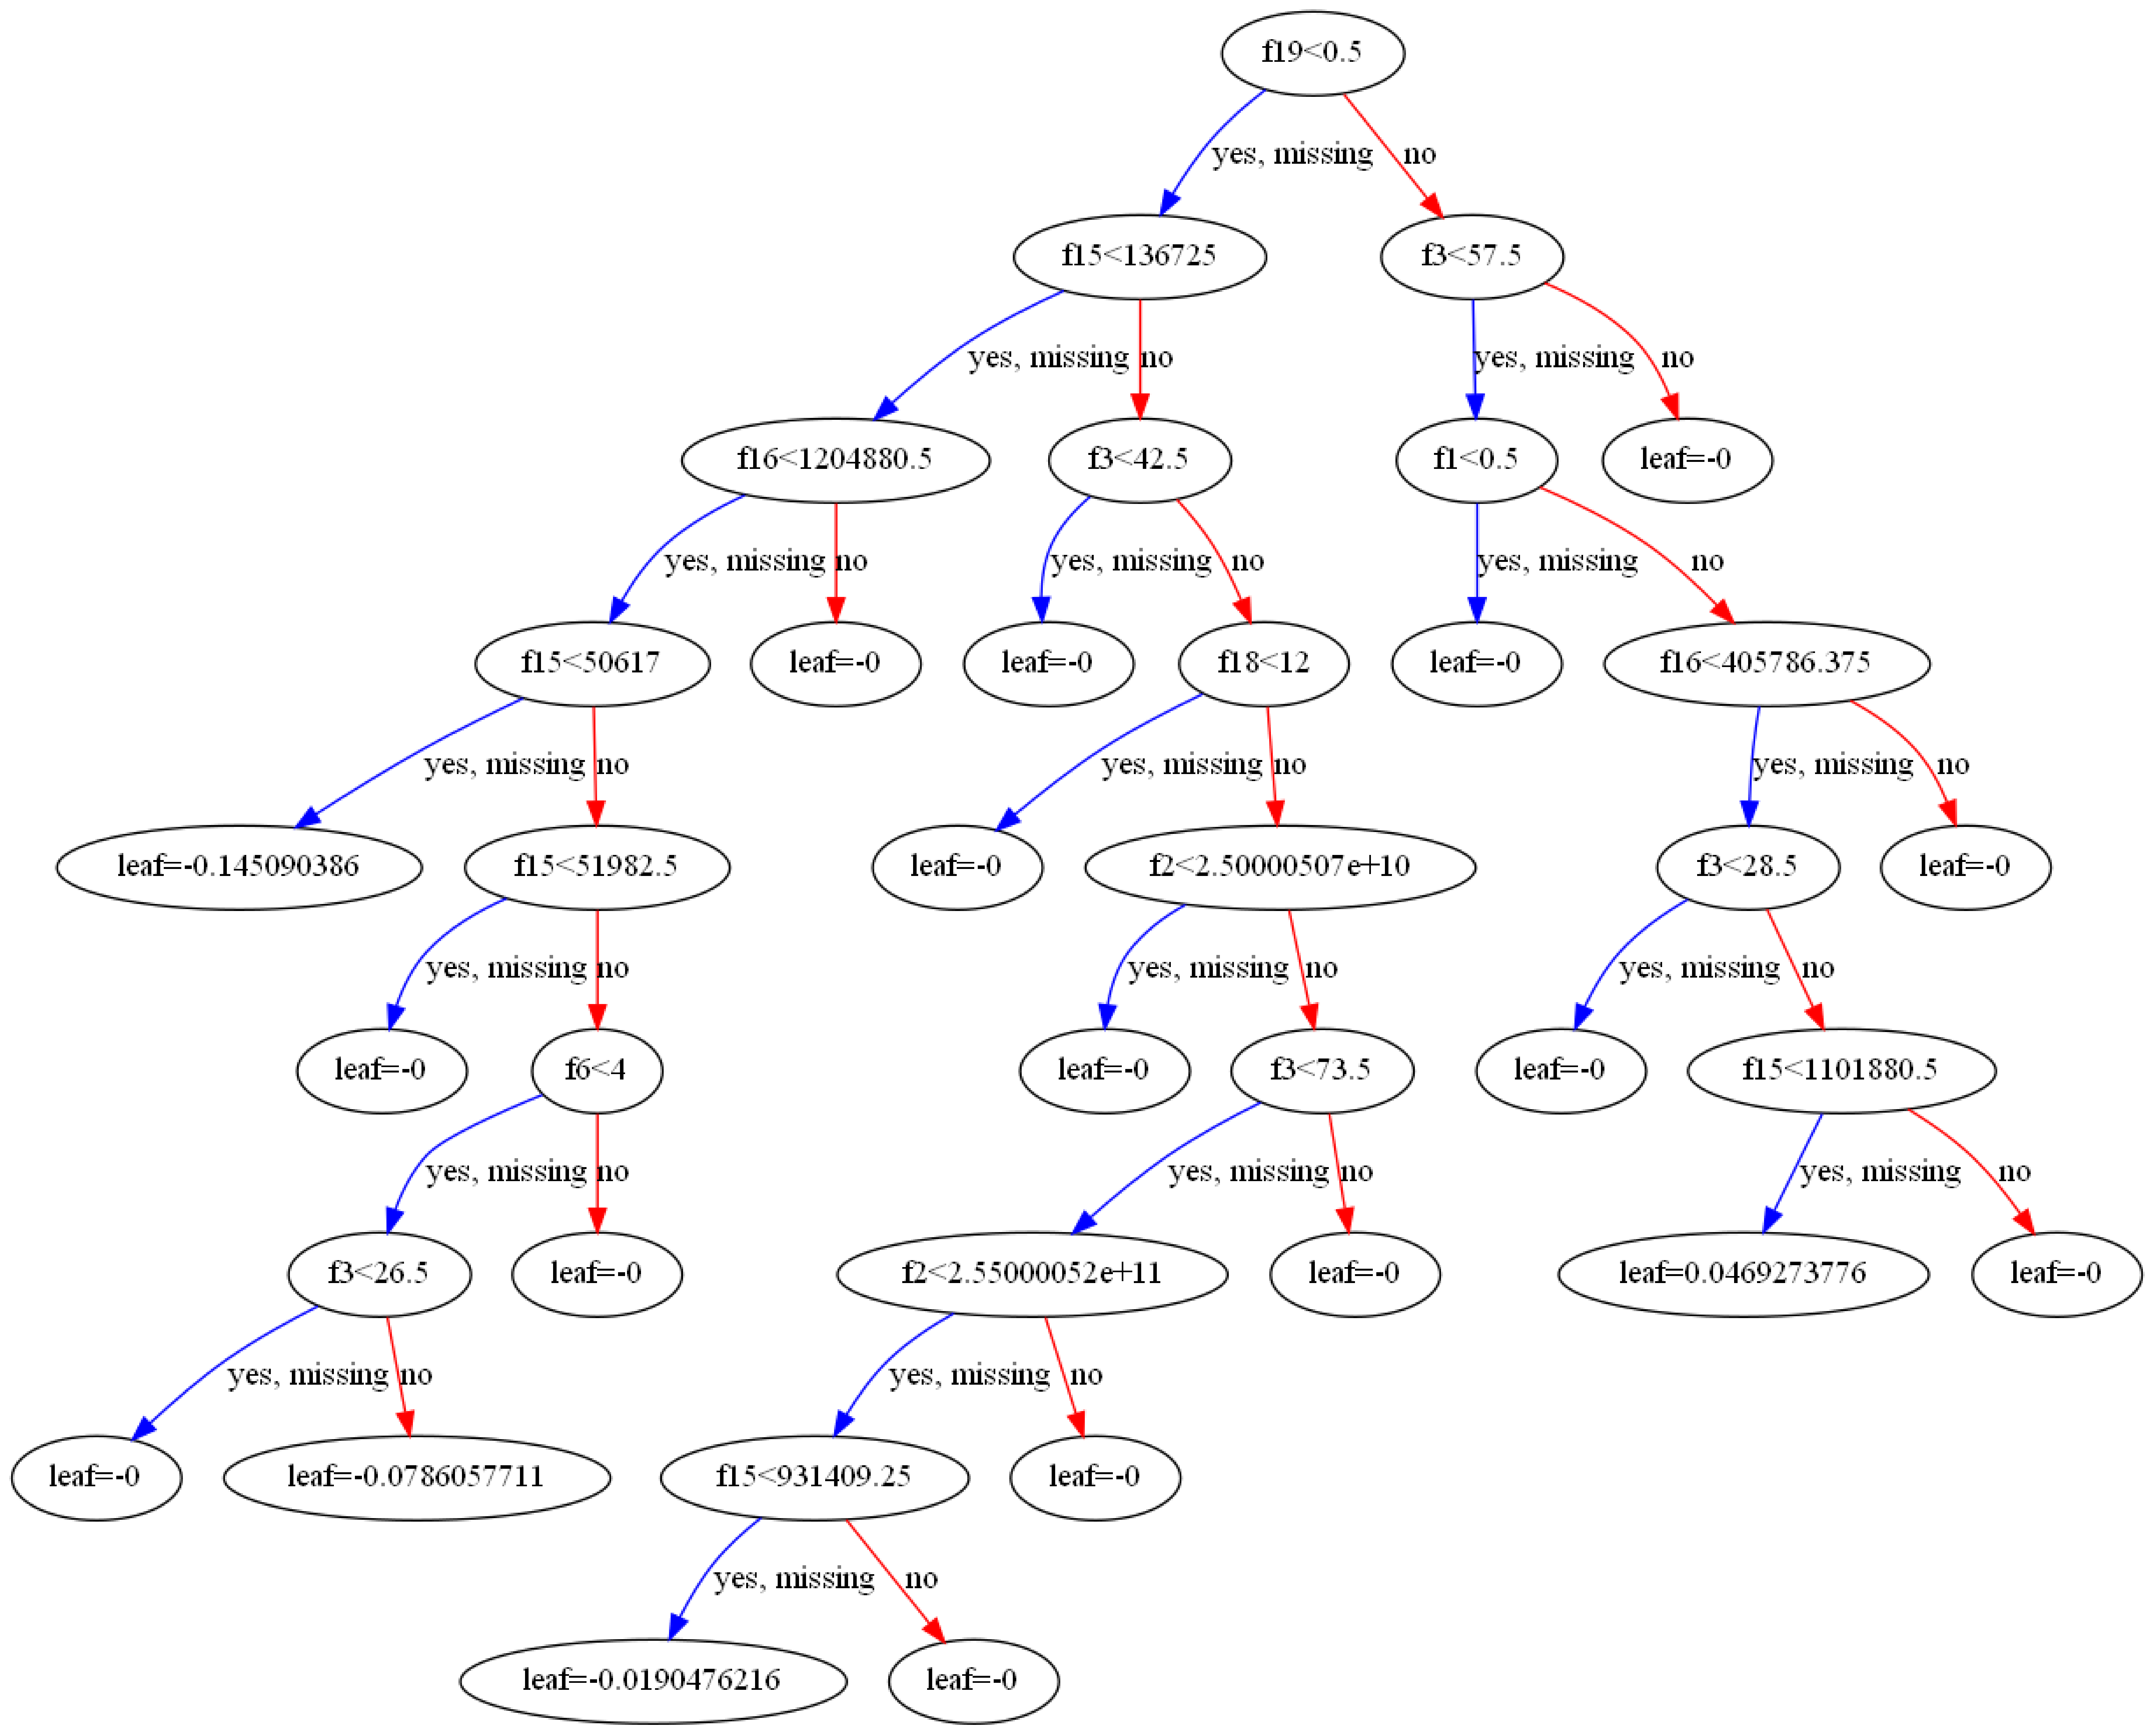

In [18]:
# Visualizing tree
xgb.plot_tree(booster = module, num_trees = 0)
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.savefig("tree.png") 

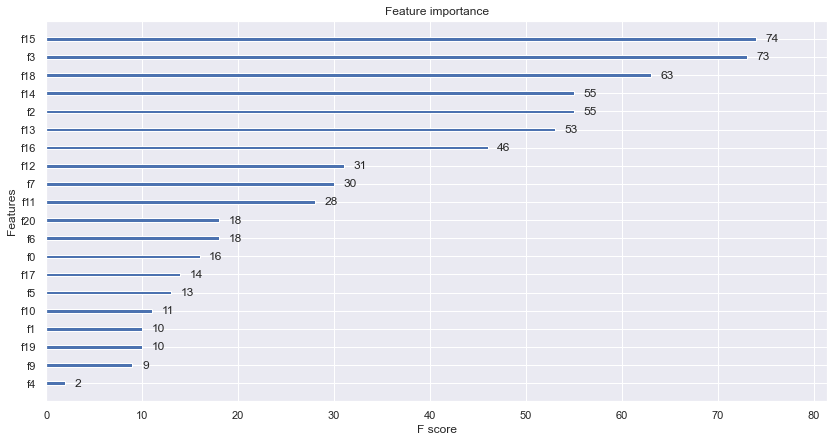

In [19]:
 # Visualizing feature importance
plt.rcParams['figure.figsize'] = [14, 7]
xgb.plot_importance(module)
plt.savefig("fi.png") 

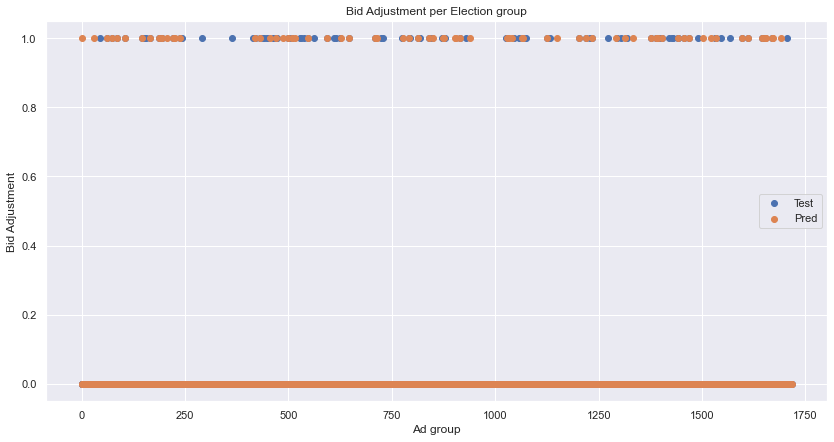

In [21]:
 # Scatter graph
epochs = len(y_pred)
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.scatter(x_axis, y_test, label='Test')
ax.scatter(x_axis, y_pred, label='Pred')
ax.legend()
plt.ylabel('Bid Adjustment')
plt.xlabel('Ad group')
plt.title('Bid Adjustment per Election group')
plt.savefig("scatter.png") 